<a href="https://colab.research.google.com/github/gralily-pixel/BlackScholes/blob/main/Pairs_trading_hood%26sofi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-219261979.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Close']
[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-219261979.py:16: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  score, p_value, _ = coint(data['HOOD'], data['SOFI'])


Cointegration test p-value: 0.0
The pairs are cointegrated.


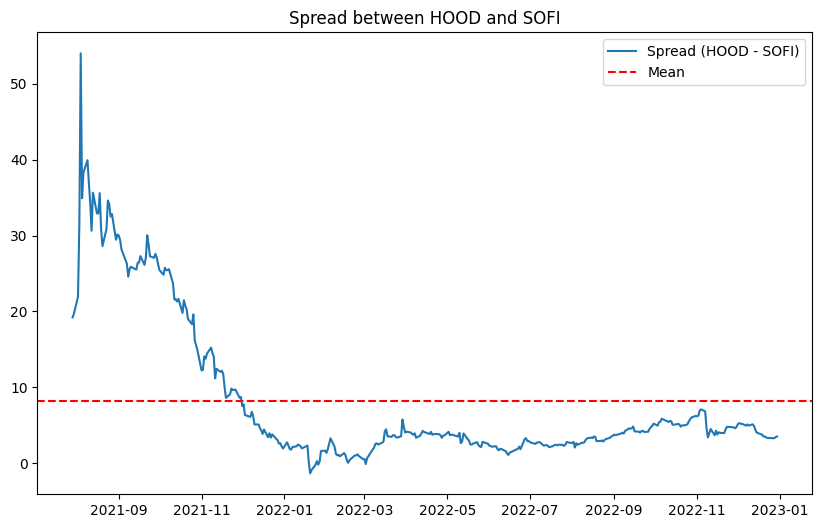

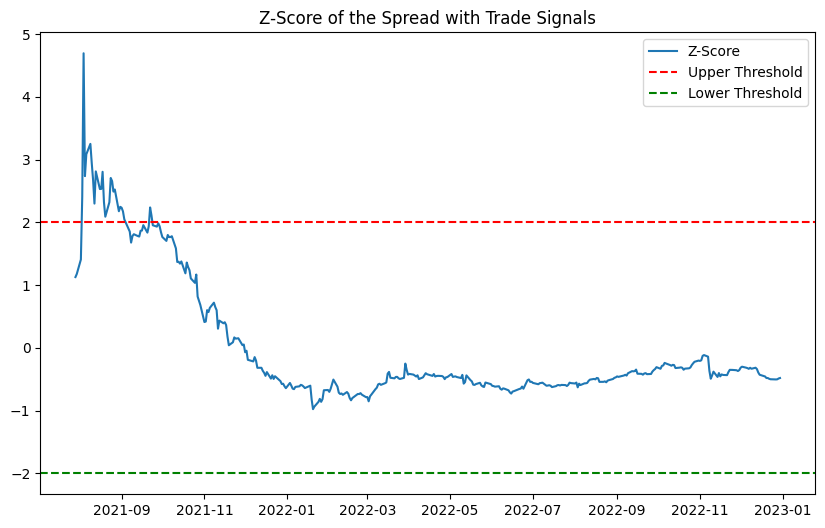

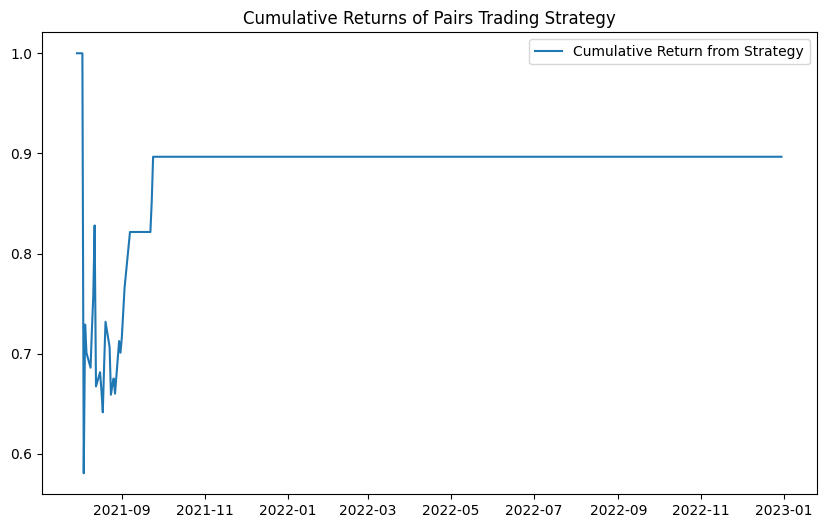

Sharpe Ratio: 0.13156446260254187
Max Drawdown: 0.4193477451003873


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# Download stock data for PepsiCo and Coca-Cola
tickers = ['HOOD', 'SOFI']
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Close']

# Preview the data
data.head()

# Perform cointegration test
score, p_value, _ = coint(data['HOOD'], data['SOFI'])

print(f'Cointegration test p-value: {p_value}')

# If p-value is low (<0.05), the pairs are cointegrated
if p_value < 0.05:
    print("The pairs are cointegrated.")
else:
    print("The pairs are not cointegrated.")
# Calculate the spread between the two stocks
data['Spread'] = data['HOOD'] - data['SOFI']

# Plot the spread
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Spread'], label='Spread (HOOD - SOFI)')
plt.axhline(data['Spread'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.title('Spread between HOOD and SOFI')
plt.show()
# Define z-score to normalize the spread
data['Z-Score'] = (data['Spread'] - data['Spread'].mean()) / data['Spread'].std()

# Set thresholds for entering and exiting trades
upper_threshold = 2
lower_threshold = -2

# Initialize signals
data['Position'] = 0

# Generate signals for long and short positions
data['Position'] = np.where(data['Z-Score'] > upper_threshold, -1, data['Position'])  # Short the spread
data['Position'] = np.where(data['Z-Score'] < lower_threshold, 1, data['Position'])   # Long the spread
data['Position'] = np.where((data['Z-Score'] < 1) & (data['Z-Score'] > -1), 0, data['Position'])  # Exit

# Plot z-score and positions
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Z-Score'], label='Z-Score')
plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title('Z-Score of the Spread with Trade Signals')
plt.show()
# Calculate daily returns
data['HOOD_Return'] = data['HOOD'].pct_change()
data['SOFI_Return'] = data['SOFI'].pct_change()

# Strategy returns: long spread means buying PEP and shorting KO
data['Strategy_Return'] = data['Position'].shift(1) * (data['HOOD_Return'] - data['SOFI_Return'])

# Cumulative returns
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Cumulative_Return'], label='Cumulative Return from Strategy')
plt.title('Cumulative Returns of Pairs Trading Strategy')
plt.legend()
plt.show()
# Calculate Sharpe Ratio
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calculate max drawdown
cumulative_max = data['Cumulative_Return'].cummax()
drawdown = (cumulative_max - data['Cumulative_Return']) / cumulative_max
max_drawdown = drawdown.max()
print(f'Max Drawdown: {max_drawdown}')